# In LangGraph, everything revolves around the **global states**
- A graph is a set of nodes following certain orders (sequences or cycles)
- Each node (typically) use the state as input, do something with it, then modify the state.
- The global state is typically a dict. When we say "change" the state, it usually means change some values in that dict.

# Let's define a super simple graph, no LLM involved

Featuring:
- a super simple state
- super simple node to change this state one at a time

Specifically, something like this:

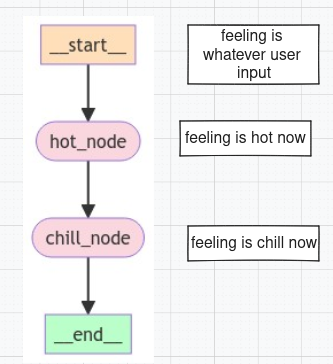

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    feeling: str

        
def hot_fn(state: State):
    return {"feeling": "hot"}

def chill_fn(state: State):
    last_feeling = state['feeling']
    return {"feeling": f"was {last_feeling} now chill"}

Explanation:
- We defined a simple global state which looks like `{'feeling': <some value>}`
- Here, `hot_node` will take `state` as input, does nothing with it but update the `feeling` (the only field in state).
- `chill_node` on the other hand, will manipulate the state before updating the `feeling` to `chill`.

To create the graph, initialize a `StateGraph` object with our state dict:

In [3]:
graph_builder = StateGraph(State)

In [4]:
type(graph_builder)

langgraph.graph.state.StateGraph

Add nodes we defined, then add edges:

In [5]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("hot_node", hot_fn)
graph_builder.add_node("chill_node", chill_fn)

graph_builder.add_edge(START, "hot_node")
graph_builder.add_edge("hot_node", "chill_node")
graph_builder.add_edge("chill_node", END)

Finally, "compile" the graph. 

In [6]:
graph = graph_builder.compile() # Compile the graph

What `compile` does:
- LangGraph checks if the graph is legit (e.g., no orphan node)
- You can also provide runtime args here like (checkpointers, breakpoints). More on this later, on another branch.

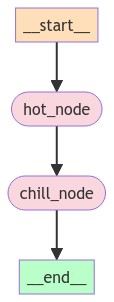

In [8]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's use this graph as end-user. Since `graph` is actually a [Runnable](https://python.langchain.com/v0.2/docs/concepts/#runnable-interface), we can use `stream`, `invoke`, etc. to get the output

In [9]:
# A graph is a Runnable
from langchain_core.runnables.base import Runnable

print(type(graph))

isinstance(graph, Runnable)

<class 'langgraph.graph.state.CompiledStateGraph'>


True

In [10]:
while True:
    # Pepertually asks for input
    user_input = input("User: ")
    
    # Exit mechanism (totally mannual)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
        
        
    for event in graph.stream({"feeling": user_input}):
        for value in event.values():
            print("Assistant:", value)

User: warm
Assistant: {'feeling': 'hot'}
Assistant: {'feeling': 'was hot now chill'}
User: cold
Assistant: {'feeling': 'hot'}
Assistant: {'feeling': 'was hot now chill'}
User: q
Goodbye!


Recap with some thoughts:
- a state is a data structure of choice. Here I used a string, but you can use a list
- nodes use the state as inputs and update the state. Here I update the string once at a time. If you use a list, you can append new state to that list, and return the updated list at the end of each node (voila, you have history)
- creating a graph in LangGraph involves:
    - create states
    - create nodes and edges
    - compile

# Conclusion

We went thru some most crucial parts of LangGraph. There are more, so take your time

# Reference

Runnable: https://python.langchain.com/v0.2/docs/concepts/#runnable-interface

Runnables are basically like special functions that not only do direct input/output but also stream, batch (sync or asynchronously)

Low-level concepts in LangGraph: https://langchain-ai.github.io/langgraph/concepts/low_level